In [4]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import Aer, assemble, transpile
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram 

path = "clauses_small.txt"
def file_read(path):
    """
    Reading file, transfering from string to list of lists, which contain single clauses
    """
    clauses = ""

    my_file = open(path, "rt")
    
    #reading file
    
    for line in my_file:
        
        clauses += line
    
    clauses = clauses.rsplit()

    #From string to list
    
    for idx, clause in enumerate(clauses):
        
        clauses[idx] = clause.split(",")
        
        clauses[idx][0] = int(clauses[idx][0])
        clauses[idx][1] = int(clauses[idx][1])

    my_file.close()

    return clauses


file_read(path)

[[0, 1], [0, 2], [1, 3], [2, 3]]

In [5]:
def Qubits_count(clauses:list):
    """
    Returns amount of qubits required for oracle and diffuser
    amount[0] contains diffuser quibts, amount[1] contains additional qubits for clause realisation, amount[2] number of all qubits needed
    """
    amount = [0, 0, 0]
    
    for cl1, cl2 in clauses:
        
        if amount[0]<cl1:
            
            amount[0] = cl1
        
        if amount[0]<cl2:
        
            amount[0] = cl2
    
    #due to 0 indexing of python we need to add 1 to diffuser qubits

    amount[0] +=1

    amount[1] = len(clauses)

    amount[2] = qubits_init = amount[1]+amount[0]+1

    return amount




In [6]:
def Init(amount:list):
    """
    Returns gate, which sets correct qubits into superposition and last qubits into |-> state
    """

    qc = QuantumCircuit(amount[2])

    print(amount[2])
    
    for qubit in range(amount[0]):
        
        qc.h(qubit)
   
    qc.x(amount[2]-1)

    init_gate = qc.to_gate()

    init_gate.name = "init"
    
    return init_gate
        

In [7]:
def Oracle(clauses:list, amount:list):
    
    """
    #Makes oracle of grovers algorithm from clauses and respective amount of neccesary qubits
    """


    qc = QuantumCircuit(amount[2])

    for idx, clause in enumerate(clauses):

        qc.cx(clause[0], idx + amount[1])

        qc.cx(clause[1], idx + amount[1])
    
    qc.mct(list(range(amount[0],amount[2]-1)), amount[2]-1)
    
    for idx, clause in enumerate(clauses):

        qc.cx(clause[0], idx + amount[1])

        qc.cx(clause[1], idx + amount[1])

    oracle_gate = qc.to_gate()

    oracle_gate.name = "oracle"
    
    return oracle_gate
    

In [8]:
def Diffuser(amount:list):

    qc = QuantumCircuit(amount[0])

    for i in range(amount[0]-1):

        qc.h(i)
        qc.x(i)

    #qc.barrier(list(range(amount[0])))

    qc.z(amount[0]-1)
    qc.mct(list(range(amount[0]-1)), amount[0]-1)
    qc.z(amount[0]-1)

    #qc.barrier(list(range(amount[0])))

    for i in range(amount[0]-1):

        qc.x(i)
        qc.h(i)

    diffuser_gate = qc.to_gate()

    diffuser_gate.name = "diffuser"

    return diffuser_gate



In [15]:
def Grovers(path: str ):
    
    """
    Algorithm it self, using previous functions to properly set up and run
    """
    
    clauses = file_read(path)
    
    amount = Qubits_count(clauses)
    
    init_gate = Init(amount)

    oracle_gate = Oracle(clauses, amount)

    diffuser_gate = Diffuser(amount)

    iterations = int( np.arcsin(1 / np.sqrt( amount[0] ) ) )
    
    #sometimes number of iterations can be near 0, in this case we increase it to 1 to make algorithm work

    if iterations == 0: iterations = 1
    
    
    
    init_qubits = list(range(amount[2]))
    
    oracle_qubits = list(range(amount[2]))
    
    diffuser_qubits = list(range(amount[0]))
    print(clauses)
    print(amount)
    
    qc = QuantumCircuit(amount[2],amount[0])

    qc.append(init_gate,init_qubits)

    for i in range(2):
            
        qc.append(oracle_gate,oracle_qubits)
        
        qc.append(diffuser_gate, diffuser_qubits)
    
    print(qc)
    qc.measure(diffuser_qubits,diffuser_qubits)
    aer_sim = Aer.get_backend('aer_simulator')
    transpiled_grover_circuit = transpile(qc, aer_sim)
    qobj = assemble(transpiled_grover_circuit)
    results = aer_sim.run(qobj).result()
    counts = results.get_counts()
    plot_histogram(counts)
    return counts

In [16]:
counts = Grovers(path)

9
     ┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     └───┘
q_4: ─────
          
q_5: ─────
          
q_6: ─────
          
q_7: ─────
     ┌───┐
q_8: ┤ X ├
     └───┘
[[0, 1], [0, 2], [1, 3], [2, 3]]
[4, 4, 9]
     ┌───────┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐
q_0: ┤0      ├┤0        ├┤0          ├┤0        ├┤0          ├
     │       ││         ││           ││         ││           │
q_1: ┤1      ├┤1        ├┤1          ├┤1        ├┤1          ├
     │       ││         ││  diffuser ││         ││  diffuser │
q_2: ┤2      ├┤2        ├┤2          ├┤2        ├┤2          ├
     │       ││         ││           ││         ││           │
q_3: ┤3      ├┤3        ├┤3          ├┤3        ├┤3          ├
     │       ││         │└───────────┘│         │└───────────┘
q_4: ┤4 init ├┤4 oracle ├─────────────┤4 oracle ├─────────────
     │       ││         │             │         │             
q_5: ┤5      ├┤5        ├─────────────┤5        ├────

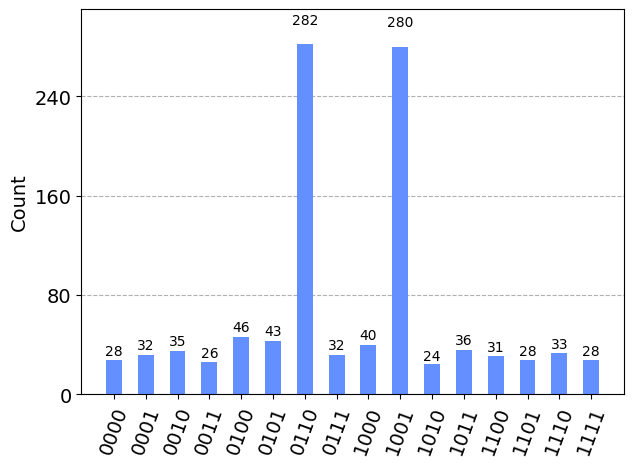

In [17]:
plot_histogram(counts)